<a href="https://colab.research.google.com/github/fenghe0/hello-world/blob/master/2D_mdn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

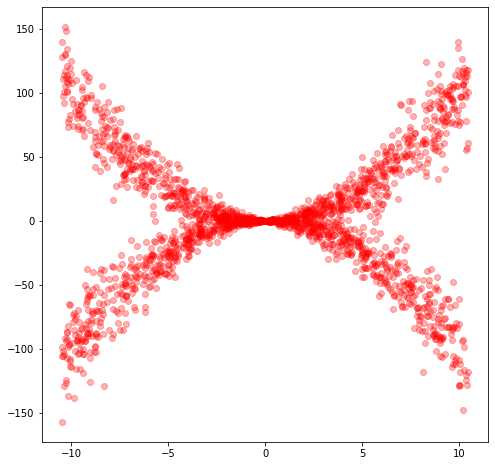

In [69]:

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
tf.disable_v2_behavior()
import math

NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.array([np.random.normal(scale=np.abs(i)) for i in x_data])
y_data = np.float32(np.square(x_data)+r_data*2.0)

x_data2 = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data2 = np.array([np.random.normal(scale=np.abs(i)) for i in x_data2])
y_data2 = np.float32(-np.square(x_data2)+r_data2*2.0)

x_data = np.concatenate((x_data,x_data2),axis=1)
y_data = np.concatenate((y_data,y_data2),axis=1)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

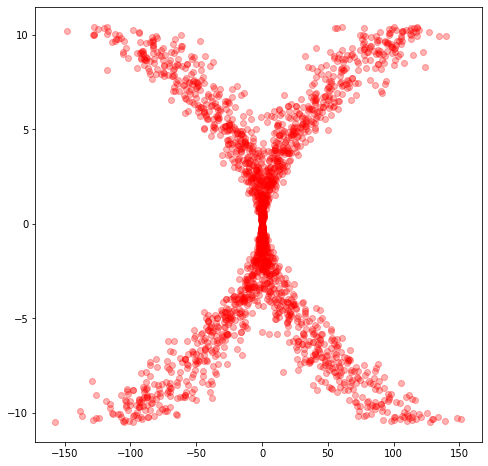

In [70]:
temp_data = x_data
x_data = y_data
y_data = temp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

In [71]:
# Neural Network

NHIDDEN = 24
STDEV = 0.5
KMIX = 4 # number of mixtures
NOUT = KMIX * 6 # pi, mu(mu_x,mu_y), stdev(stdev_x,stdev_y),rho

x = tf.placeholder(dtype=tf.float32, shape=[None,2], name="x")# [None,2]

y = tf.placeholder(dtype=tf.float32, shape=[None,2], name="y")# [None,2]


Wh = tf.Variable(tf.random_normal([2,NHIDDEN], stddev=STDEV, dtype=tf.float32))# [2,24]
bh = tf.Variable(tf.random_normal([2,NHIDDEN], stddev=STDEV, dtype=tf.float32))# [2,24]

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))# [24,24]
bo = tf.Variable(tf.random_normal([2,NOUT], stddev=STDEV, dtype=tf.float32))# [2,24]

hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)# [2,24]
output = tf.matmul(hidden_layer,Wo) + bo#[2,24]

In [72]:

def get_mixture_coef(output):
  out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="out_pi")# [2,4]
  out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX,2], name="out_sigma")# [2,4,2]
  out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX,2], name="out_mu")# [2,4,2]
  out_rho= tf.placeholder(dtype=tf.float32, shape=[None, KMIX], name="out_rho")  # [2,4]

  out_pi, out_rho, out_sigma_x, out_sigma_y, out_mu_x, out_mu_y = tf.split(output, 6, 1)
  out_sigma = tf.stack([out_sigma_x, out_sigma_y], axis=2)
  out_mu = tf.stack([out_mu_x, out_mu_y], axis=2)

  max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
  out_pi = tf.subtract(out_pi, max_pi)
#To aviod
#Overflow: It occurs when very large numbers are approximated as infinity
#Underflow: It occurs when very small numbers (near zero in the number line)
#are approximated (i.e. rounded to) as zero
  out_pi = tf.exp(out_pi)

  normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keepdims=True))# daoshu
  out_pi = tf.multiply(normalize_pi, out_pi)

  out_sigma = tf.exp(out_sigma)
  
  out_rho = tf.math.tanh(out_rho)

  return out_pi, out_sigma, out_mu, out_rho

out_pi, out_sigma, out_mu, out_rho = get_mixture_coef(output)

In [73]:

# Normal distribution for 2D data
def tf_normal(y, mu, sigma, rho):
    print(mu[:, :, 0], y[:, 0])
    z_1 = tf.divide(tf.square(tf.subtract(mu[:, :, 0], tf.expand_dims(y[:, 0], -1))),
                    tf.square(sigma[:, :, 0]))
    print(mu[:, :, 1], y[:, 1])
    z_2 = tf.divide(tf.square(tf.subtract(mu[:, :, 1], tf.expand_dims(y[:, 1], -1))),
                    tf.square(sigma[:, :, 1]))

    z_3 = tf.multiply(2 * rho, tf.multiply(tf.subtract(mu[:, :, 0], tf.expand_dims(y[:, 0], -1)),
                                           tf.subtract(mu[:, :, 1], tf.expand_dims(y[:, 1], -1))))
    z_3 = tf.divide(z_3, tf.multiply(sigma[:, :, 0], sigma[:, :, 1]))

    Z = z_1 + z_2 - z_3

    N = tf.divide(-Z, 2 * (tf.ones_like(rho) - tf.square(rho)))
    N = tf.exp(N)

    normalizer = 2 * math.pi * tf.multiply(sigma[:, :, 0], sigma[:, :, 1])
    normalizer = tf.multiply(normalizer, tf.sqrt(tf.ones_like(rho) -
                                                 tf.square(rho)))
    normalizer = tf.reciprocal(normalizer)

    N = tf.multiply(normalizer, N)

    return N
# Loss function
def get_lossfunc(out_pi, out_mu, out_sigma, out_rho, y):
    result = tf_normal(y, out_mu, out_sigma, out_rho)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keepdims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)
# To get the average loss over the batch.

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu ,out_rho, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

Tensor("strided_slice_144:0", shape=(2, 4), dtype=float32) Tensor("strided_slice_145:0", shape=(?,), dtype=float32)
Tensor("strided_slice_149:0", shape=(2, 4), dtype=float32) Tensor("strided_slice_150:0", shape=(?,), dtype=float32)


In [74]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NEPOCH = 1000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
    sess.run(train_op, feed_dict={x: x_data, y: y_data})
    loss[i], pi_, mu_, sig_, ro_, op_ = sess.run([lossfunc, out_pi, out_mu, out_sigma, out_rho, model_op],
                                                     feed_dict={x: x_data, y: y_data})
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH, 1), loss[100:], 'r-')
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


InvalidArgumentError: ignored